# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or Chapter 4 of the code repo if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file. 

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.*


***
##  Task 1: SEE THE BIG PICTURE (5 pts)
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

In [350]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Your code goes here for this section, make sure you also include the output to answer the above questions.
insurance = pd.read_csv('/insurance.csv')
insurance.head()



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [351]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


In [352]:
insurance.shape

(1338, 7)

In [353]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010





*   The dataset is 73.2 KB, which is 0.07 MB.
*   It has 1388 entries and 7 features.
*   Three columns contain categorical data. They are "sex", "smoker", "region".
*   There is no missing values because each column has 1388 non-null values .
*   Basic statistics are given above. 



---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING (25 pts)

**Data Discover:** Plot out all correlations among the features. You may notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class. 

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

In [0]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [355]:
corr_matrix = insurance.corr()
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2505b57940>,
      dtype=object)

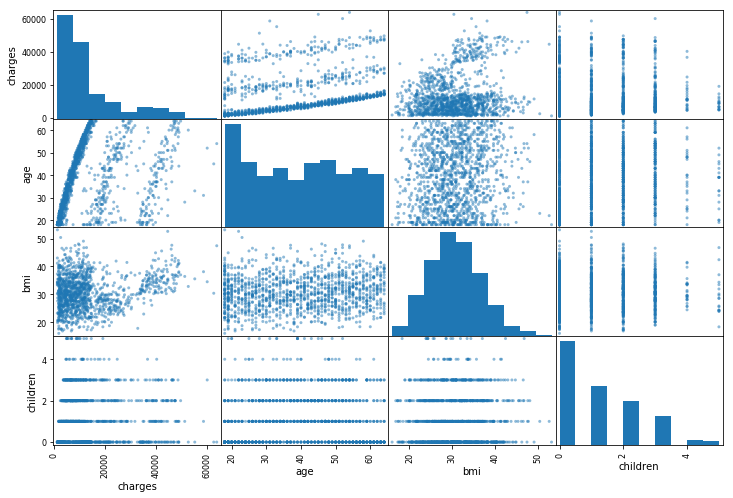

In [356]:
attributes = ["charges", "age", "bmi",
              "children"]
scatter_matrix(insurance[attributes], figsize=(12, 8))

In [0]:
#Seperate features and target.
X = insurance.drop(['charges'],axis=1)
y = insurance['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
#Use pipeline to prepare numerical values
pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

#Use pipeline to handle all columns
from sklearn.compose import ColumnTransformer

insurance_num = X[['age','bmi','children']]
num_attribs = list(insurance_num)
cat_attribs = ['sex','smoker','region']

full_pipeline = ColumnTransformer([
        ("num", pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.fit_transform(X_test)




- - -
## Task 3. IMPLEMENT GRADIENT DESCENT (30 pts)
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods. 

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [0]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = 0 with value from your implementation

class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self):
    """
    Initialize the regressor
    """
    self.theta = np.random.randn(12,); # parameter vector;
    self.alpha = 0.35; # learning rate
    self.cost  = []; # cost function

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations
        
    OUTPUT: 
    theta: updated value for theta
    cost: value of the cost function
    """
    # implementation code here
   
    cost = []
    for iter in range(iters):
      grad = (2/len(y_train))* (X_train.T.dot(X_train.dot(theta)-y_train))
      theta = theta - alpha*grad
      cost_value = (1/len(y_train))*np.sum(np.square(X_train.dot(theta)-y_train))
      cost = cost + [cost_value]

    return theta, cost
    
  def fitUsingGradientDescent(self, X_train, y_train):
    """
    Train the regressor using gradient descent
    """
    # implementation code here
    X_b = np.c_[np.ones((len(X_train),1)), X_train]
    theta_best, cost = self.gradientDescent(X_b, y_train, self.theta, self.alpha, 1000)
    self.theta = theta_best
    self.cost = cost
    
  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    # implementation code here for Task 4.
    X_b = np.c_[np.ones((len(X_train),1)), X_train]
    theta_best2 = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)
    self.theta = theta_best2
    
  def predict(self, X_test):
    """
    Predicting the label
    """
    # implementation code here 
    X_b_test = np.c_[np.ones((len(X_test),1)), X_test]
    y_predict = X_b_test.dot(self.theta)
    return y_predict
    
  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    print("Parameter vector is %f" % self.theta)
    print("Learning rate is %f" % self.alpha)
    print("Cost is %f" % self.cost)
    
# Your code goes here to call the instance of class MyLinearRegression
myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)


* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

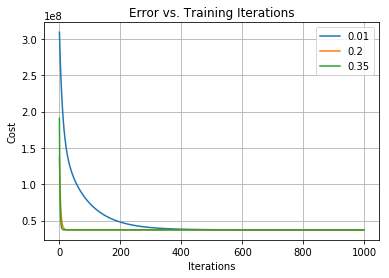

In [360]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You may plot multiple curves corresponding to different learning rates to justify the best one.
#
learning_rates = [0.01, 0.2, 0.35]

for lr in learning_rates:
    myGradientDescentModel_new = MyLinearRegression()
    myGradientDescentModel_new.alpha = lr
    myGradientDescentModel_new.fitUsingGradientDescent(X_train, y_train)
    plt.plot(myGradientDescentModel_new.cost)

plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations') 
plt.legend(list(map(str, learning_rates)))
plt.grid()

Based on the plot above, 0.35 is the best learning rate, because the curve with 0.35 learning rate decays to a small value most quickly.

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION (10 pts)

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement: 

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [0]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)

- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS (20 pts)

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you may also use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [362]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor(random_state=42)
mySGDModel.fit(X_train, y_train)
y_predict1 = mySGDModel.predict(X_test)
mse1 = mean_squared_error(y_test, y_predict1)
mySGDModel_rmse = np.sqrt(mse1)
print(mySGDModel_rmse)

# myGradientDescentModel_rmse  
y_predict2 = myGradientDescentModel.predict(X_test)
mse2 = mean_squared_error(y_test, y_predict2)
myGradientDescentModel_rmse = np.sqrt(mse2)
print(myGradientDescentModel_rmse)

# myNormalEquationModel_rmse 
y_predict3 = myNormalEquationModel.predict(X_test)  
mse3 = mean_squared_error(y_test, y_predict3)
myNormalEquationModel_rmse = np.sqrt(mse3)
print(myNormalEquationModel_rmse)



5930.060114112978
5926.56252740305
5926.56252740305




*   The two self-implemented models have the same RMSE, which are a little bit smaller than the SGD model. The myGradientDescentModel and myNormalEquationModel have better performance. 
*   I would like to say the error is accpetable and my self-implemented models do a good job in predicting the cost.



- - -
## Task 6. PRESENT YOUR SOLUTION (10 pts)

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following: 

* How can you pitch your solution to this project? 
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.



*   For this dataset, I implemented two models which use different methods to calculate theta. I compared the error given by these two models with a built-in model called Scholastic Gradient Descent (SGD). The error from two self-implemented models are the same and smaller than that of SGD model. It shows that the two self-implemented models are effective and do a better job in predicting the cost.
*   From this project, I learned about how to calculate theta with Normal Equation and Gradient Descent. Also, this project made me more familiar with data pre-processing pipeline and how models work. 
*   To carry this project forward, we should try other regression algorithms, like Lasso or Logistic. By comparing RMSE, we may be able to improve our solution.



- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 1:...".

Best of luck and have fun!